Before dropna: 21799
After dropna: 9911


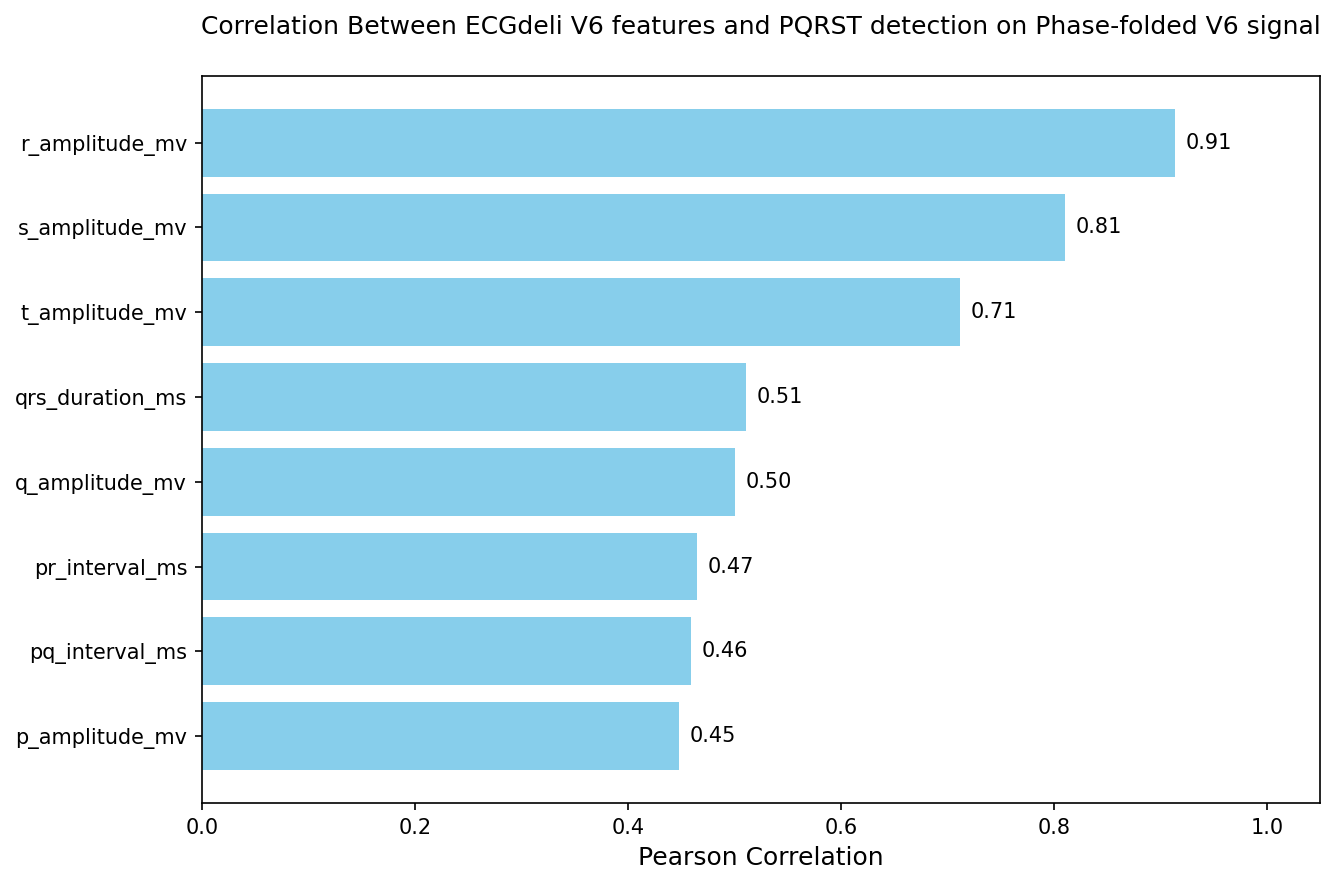

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --------------- FILE PATHS (FILL THESE) ---------------- #
your_csv_path = '/Users/rohanmotanavar/Dissertation ECG Parameterization/Pipeline4_PQRST_detection/PQRST/PQRST_Complexes_and_Features_final.csv'  # Replace with your actual path
ecgdeli_csv_path = '/Users/rohanmotanavar/Dissertation ECG Parameterization/Pipeline5_Correlation_with_ecgdeli/corr/ecgdeli_selected_clinical_features.csv'  # Replace with your actual path

# --------------- LOAD CSVs ---------------- #
your_df = pd.read_csv(your_csv_path)
ecgdeli_df = pd.read_csv(ecgdeli_csv_path)

# --------------- FEATURE MAPPING ---------------- #
column_mapping = {
    "PQ_Int_V6": "pq_interval_ms",
    "PR_Int_V6": "pr_interval_ms",
    "P_Amp_V6": "p_amplitude_mv",
    "P_DurFull_V6": "p_duration_ms",
    "Q_Amp_V6": "q_amplitude_mv",
    "QRS_Dur_V6": "qrs_duration_ms",
    "QT_IntCorr_V6": "qtc_bazett_ms",
    "QT_Int_V6": "qt_interval_ms",
    "R_Amp_V6": "r_amplitude_mv",
    "S_Amp_V6": "s_amplitude_mv",
    "ST_Elev_V6": "st_elevation_mv",
    "T_Amp_V6": "t_amplitude_mv",
    "T_DurFull_V6": "t_duration_ms"
}

# --------------- MERGE AND CLEAN ---------------- #
df_deli = ecgdeli_df[['ecg_id'] + list(column_mapping.keys())].rename(columns=column_mapping)
df_yours = your_df[['ecg_id'] + list(column_mapping.values())]

merged = pd.merge(df_deli, df_yours, on='ecg_id', suffixes=('_v6', '_extracted'))

# Print row count before and after dropna
print("Before dropna:", merged.shape[0])
merged_clean = merged.dropna()
print("After dropna:", merged_clean.shape[0])

# --------------- CORRELATION MATRIX ---------------- #
corr_matrix = merged_clean.drop(columns=['ecg_id']).corr().loc[
    [f"{v}_v6" for v in column_mapping.values()],
    [f"{v}_extracted" for v in column_mapping.values()]
]

# --------------- FILTER FOR THESIS PLOT ---------------- #
# Features to include (remove low-relevance ones)
features_to_remove = [
    "p_duration_ms", "st_elevation_mv",
    "qtc_bazett_ms", "qt_interval_ms", "t_duration_ms"
]

# Extract and filter correlation pairs
corr_pairs = [
    (feature.replace('_v6', ''), corr_matrix.loc[feature, f"{feature.replace('_v6', '')}_extracted"])
    for feature in corr_matrix.index
]

filtered_corr_pairs = [
    (feature, value) for feature, value in corr_pairs
    if feature not in features_to_remove
]

# Sort descending and reverse for top-down plotting
filtered_corr_pairs_sorted = sorted(filtered_corr_pairs, key=lambda x: x[1], reverse=True)
features_sorted, correlations_sorted = zip(*filtered_corr_pairs_sorted)
features_sorted_rev = features_sorted[::-1]
correlations_sorted_rev = correlations_sorted[::-1]

# --------------- PLOT ---------------- #
plt.figure(figsize=(9, 6), dpi=150)
bars = plt.barh(features_sorted_rev, correlations_sorted_rev, color='skyblue')
plt.xlabel("Pearson Correlation", fontsize=12)
plt.title(
    "Correlation Between ECGdeli V6 features and PQRST detection on Phase-folded V6 signal",
    fontsize=12,
    pad=20,
    loc='center'  # ensures title is centered above the plot
)

# Annotate bars without overflowing
for bar in bars:
    width = bar.get_width()
    x_position = min(width + 0.01, 0.98)
    plt.text(
        x_position,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.2f}",
        va='center',
        ha='left',
        fontsize=10
    )

plt.xlim(0, 1.05)
plt.tight_layout()
plt.savefig("ecg_feature_correlation_barplot.png", dpi=300, bbox_inches='tight')
plt.show()

# Save the full correlation matrix too
corr_matrix.to_csv("ecg_feature_correlation_barplot.csv")
